<a href="https://colab.research.google.com/github/DT6A/JBPULearning/blob/master/JBPULearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import modules

In [0]:
import numpy as np
import sklearn.datasets as datasets
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Set matplotlib figures size

In [0]:
plt.rcParams["figure.figsize"] = (7, 7)

# Binary classifitaction

## Functionality

Size for the datasets

In [0]:
DATA_SIZE = 3000

Neural network classifiers

In [0]:
class GClassifier(nn.Module):
  def __init__(self):
    super(GClassifier, self).__init__()
    
    self.fc1 = nn.Linear(2, 10)
    self.act1 = nn.ELU()
    self.fc2 = nn.Linear(10, 30)
    self.act2 = nn.ELU()
    self.fc3 = nn.Linear(30, 1)
    self.act3 = nn.Sigmoid()

  def forward(self, X):
    X = self.fc1(X)
    X = self.act1(X)
    X = self.fc2(X)
    X = self.act2(X)
    return self.act3(self.fc3(X))

class FClassifier(nn.Module):
  def __init__(self, g_model, c):
    super(FClassifier, self).__init__()
    
    self.g_model = g_model
    self.c = c
  
  def forward(self, X):
    return self.g_model(X) / self.c

Useful functions

In [0]:
'''
  Shuffle data and split it to train, test, validation sets
  Arguments:
    X -- objects
    y -- labels
    s -- labeled data
    train_size -- fraction of the train set size
    test_size -- fraction of the test set size
    valid_size -- fraction of the validation set size
  Returns: Tuple of sets
'''
def split_and_suffle_data(X, y, s, train_size = 0.7, test_size=0.15, valid_size=0.15):
  premut = np.random.permutation(DATA_SIZE)

  X = X[premut]
  y = y[premut]
  s = s[premut]

  X_train = torch.Tensor(X[:int(DATA_SIZE * train_size)])
  X_valid = torch.Tensor(X[int(DATA_SIZE * train_size):int(DATA_SIZE * train_size) + int(DATA_SIZE * valid_size)])
  X_test = torch.Tensor(X[int(DATA_SIZE * train_size) + int(DATA_SIZE * valid_size):])

  y_train = torch.Tensor(y[:int(DATA_SIZE * train_size)]).reshape(-1, 1)
  y_valid = torch.Tensor(y[int(DATA_SIZE * train_size):int(DATA_SIZE * train_size) + int(DATA_SIZE * valid_size)]).reshape(-1, 1)
  y_test = torch.Tensor(y[int(DATA_SIZE * train_size) + int(DATA_SIZE * valid_size):]).reshape(-1, 1)

  s_train = torch.Tensor(s[:int(DATA_SIZE * train_size)]).reshape(-1, 1)
  s_valid = torch.Tensor(s[int(DATA_SIZE * train_size):int(DATA_SIZE * train_size) + int(DATA_SIZE * valid_size)]).reshape(-1, 1)
  s_test = torch.Tensor(s[int(DATA_SIZE * train_size) + int(DATA_SIZE * valid_size):]).reshape(-1, 1)

  return (
      X_train, y_train, s_train,
      X_test, y_test, s_test,
      X_valid, y_valid, s_valid,
  )

'''
  Plot data
  Arguments:
    X -- objects
    y -- labels
    show -- show plot at the end of the function
    Returns: None
'''
def plot_original_data(X, y, show=True):
  plt.scatter(X[y.astype(bool), 0], X[y.astype(bool), 1], c='orange', alpha=0.3, label="Class 1")
  plt.scatter(X[y.astype(bool)==0, 0], X[y.astype(bool)==0, 1], c='blue', alpha=0.3, label="Class 2")
  plt.title("Original data")
  plt.legend()
  if show:
    plt.show()

'''
  Plot labeled data
  Arguments:
    X -- objects
    s -- labeled data
    Returns: None
'''
def plot_labled_data(X, s):  
  plt.scatter(X[s.astype(bool)==0, 0], X[s.astype(bool)==0, 1], c='red', alpha=0.3, label="Unlabled")
  plt.scatter(X[s.astype(bool), 0], X[s.astype(bool), 1], c='green', alpha=0.3, label="Labled")
  plt.title("Labled/unlabled data")
  plt.legend()
  plt.show()

'''
  Plot prediction resulsts comaperd with original data
  Arguments:
    X -- original objects
    y -- original labels
    X_valid --  validation objects
    pred -- predictions for validation data
    Returns: None
'''
def plot_result(X, y, X_valid, pred):
  plot_original_data(X, y, False)
  plt.scatter(X_valid[pred, 0], X_valid[pred, 1], c='red', alpha=1.0, label="Class 1 prediction")
  plt.scatter(X_valid[pred==0, 0], X_valid[pred==0, 1], c='purple', alpha=1.0, label="Class 2 prediction")
  plt.title("Classification on validation data")
  plt.legend()
  plt.show()
  
'''
  Train g classifier
  Arguments:
    net -- pytorch neural network classifier
    X_train -- train objects
    y_train -- train labels
    X_test -- test objects
    y_test -- test labels
    batch_size -- batch size
    epoches -- number of epoches
    Returns: None
'''
def train_g(net, X_train, y_train, X_test, y_test, batch_size=100, epoches=10):
  loss = nn.BCELoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

  for e in range(epoches):
    order = np.random.permutation(len(X_train))
    for start_ind in range(0, len(X_train), batch_size):
      optimizer.zero_grad()
      
      indicies = order[start_ind:start_ind + batch_size]
      X_batch = X_train[indicies]
      y_batch = y_train[indicies]
      
      y_pred = net(X_batch)

      loss_value = loss(y_pred, y_batch)
      loss_value.backward()

      optimizer.step()

    print("Epoch: {}, accuracy: {}".format(e, ((net(X_test) > 0.5) == y_test).float().mean()))

In [0]:
'''
  Process dataset
  Arguments:
    X -- objects
    y -- labels
    s -- labeled data
    name -- dataset name
    Returns: None
'''
def process_data(X, y, s, name=None):
    if name:
      print(name)
    X_train, y_train, s_train, X_test, y_test, s_test, X_valid, y_valid, s_valid = split_and_suffle_data(X, y, s)

    plot_original_data(X, y)
    plot_labled_data(X, s)

    g_net = GClassifier()

    print("Training g classifier")
    train_g(g_net, X_train, s_train, X_test, s_test)
    print()

    c = g_net(X_test[s_test.bool().reshape(-1)]).mean()
    print("c value: {}".format(c))
    f_net = FClassifier(g_net, c)

    f_pred = f_net(X_valid) > 0.5
    print("Resulting classifier accuracy: {}".format((f_pred == y_valid).float().mean()))
    plot_result(X_train.numpy(), y_train.numpy().reshape(-1), X_valid.numpy(), f_pred.reshape(-1))

## Working with datasets

In [0]:
labeled = np.hstack([np.zeros(DATA_SIZE - DATA_SIZE // 2), np.random.randint(0, 2, DATA_SIZE // 2)])

X_blobs, y_blobs = datasets.make_blobs(n_samples=DATA_SIZE, cluster_std=3.0, centers=2, random_state=42, shuffle=False)
X_moons, y_moons = datasets.make_moons(n_samples=DATA_SIZE, noise=0.2, random_state=42, shuffle=False)

BLOBS DATA


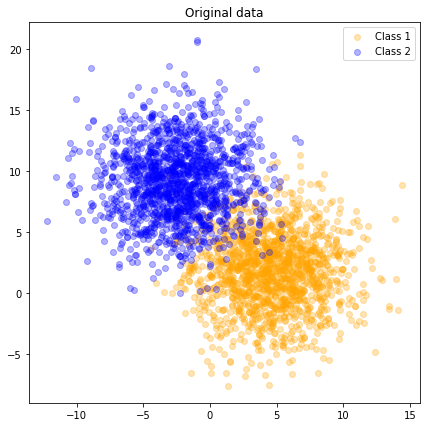

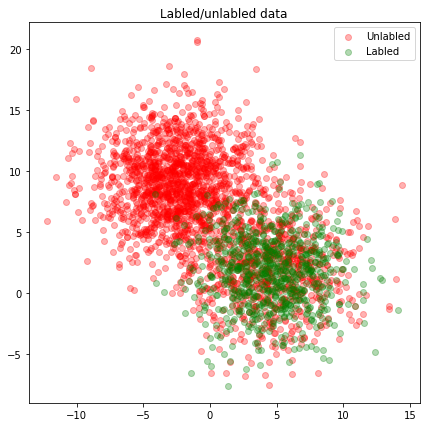

Training g classifier
Epoch: 0, accuracy: 0.7288888692855835
Epoch: 1, accuracy: 0.7377777695655823
Epoch: 2, accuracy: 0.746666669845581
Epoch: 3, accuracy: 0.7511110901832581
Epoch: 4, accuracy: 0.7666666507720947
Epoch: 5, accuracy: 0.7688888907432556
Epoch: 6, accuracy: 0.757777750492096
Epoch: 7, accuracy: 0.7622222304344177
Epoch: 8, accuracy: 0.7666666507720947
Epoch: 9, accuracy: 0.753333330154419

c value: 0.46219098567962646
Resulting classifier accuracy: 0.9444444179534912


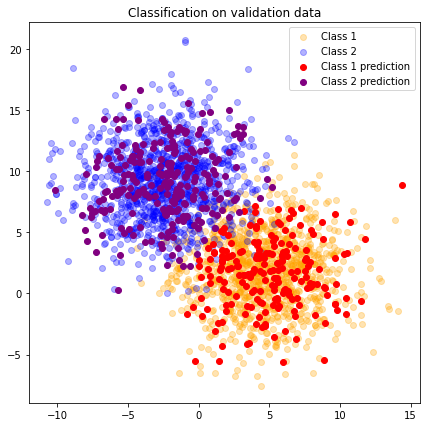

In [8]:
process_data(X_blobs, y_blobs, labeled, "BLOBS DATA")

MOONS DATA


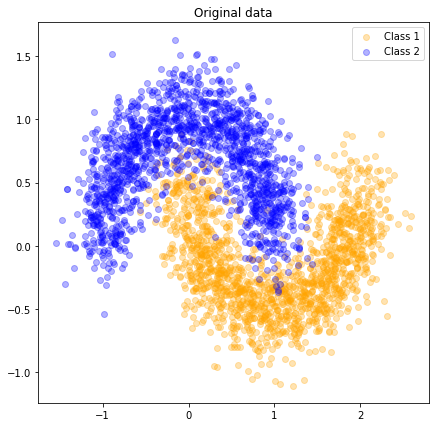

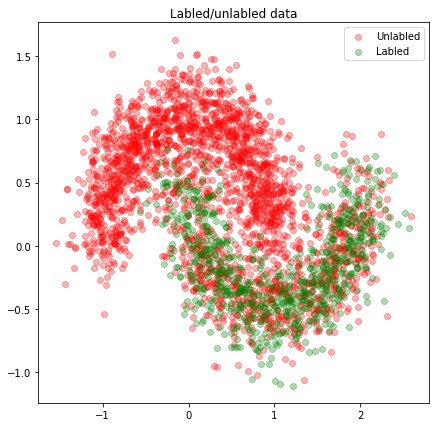

Training g classifier
Epoch: 0, accuracy: 0.6866666674613953
Epoch: 1, accuracy: 0.7644444704055786
Epoch: 2, accuracy: 0.7644444704055786
Epoch: 3, accuracy: 0.7644444704055786
Epoch: 4, accuracy: 0.7666666507720947
Epoch: 5, accuracy: 0.7622222304344177
Epoch: 6, accuracy: 0.7755555510520935
Epoch: 7, accuracy: 0.7777777910232544
Epoch: 8, accuracy: 0.7844444513320923
Epoch: 9, accuracy: 0.7844444513320923

c value: 0.39978814125061035
Resulting classifier accuracy: 0.8711110949516296


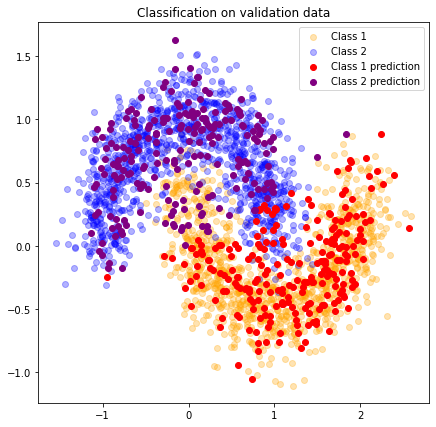

In [9]:
process_data(X_moons, y_moons, labeled, "MOONS DATA")

CLASSIFICATION DATA


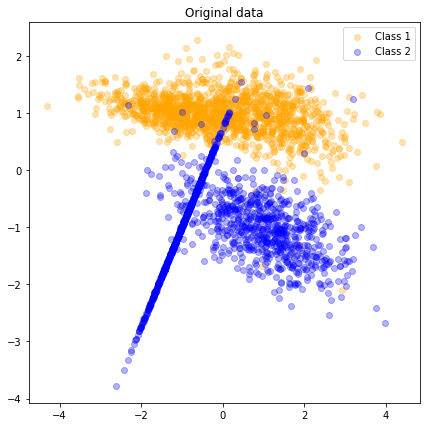

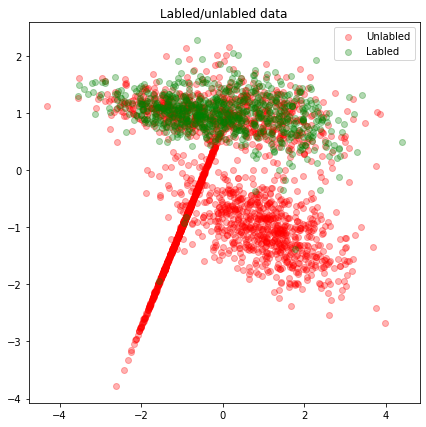

Training g classifier
Epoch: 0, accuracy: 0.7711111307144165
Epoch: 1, accuracy: 0.7400000095367432
Epoch: 2, accuracy: 0.7400000095367432
Epoch: 3, accuracy: 0.7488889098167419
Epoch: 4, accuracy: 0.7599999904632568
Epoch: 5, accuracy: 0.7622222304344177
Epoch: 6, accuracy: 0.7688888907432556
Epoch: 7, accuracy: 0.7688888907432556
Epoch: 8, accuracy: 0.757777750492096
Epoch: 9, accuracy: 0.7599999904632568

c value: 0.45173510909080505
Resulting classifier accuracy: 0.9711111187934875


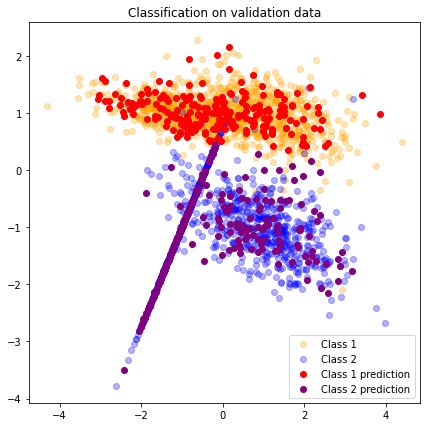

In [10]:
X_class, y_class = datasets.make_classification(n_samples=DATA_SIZE, n_features=2, n_redundant=0, random_state=42, shuffle=False)

labeled = []

for i in range(DATA_SIZE):
  if y_class[i] == 1:
    labeled.append(np.random.randint(0, 2))
  else:
    labeled.append(0)
    
labeled = np.array(labeled)
process_data(X_class, y_class, labeled, "CLASSIFICATION DATA")

# Multiclass classification

## MNIST

One versus all classification

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
import torchvision.datasets

In [0]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [0]:
X_MNIST = MNIST_train.train_data.unsqueeze(1).float() / 255
y_MNIST = MNIST_train.train_labels

X_MNIST_valid = MNIST_test.test_data.unsqueeze(1).float() / 255
y_MNIST_valid = MNIST_test.test_labels

Binatry neural network classifier classifier

In [0]:
class GClassifier_MNIST(nn.Module):
  def __init__(self):
    super(GClassifier_MNIST, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
    self.act1 = nn.ELU()
    self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
    self.act2 = nn.ELU()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(7 * 7 * 16, 100)
    self.act3 = nn.ELU()
    self.fc2 = nn.Linear(100, 1)
    self.act4 = nn.Sigmoid()
    
  def forward(self, X):
    X = self.conv1(X)
    X = self.act1(X)
    X = self.pool1(X)
    
    X = self.conv2(X)
    X = self.act2(X)
    X = self.pool2(X)
    
    X = X.view(X.size(0), X.size(1) * X.size(2) * X.size(3))

    X = self.fc1(X)
    X = self.act3(X)
    X = self.fc2(X)

    return self.act4(X)

Functions

In [0]:
'''
  Split data, set lables and labled data to train and test data sets
  Arguments:
    X -- objects
    y -- labels
    digit -- digit to create data
  Returns: Tuple of sets
'''
def preprocess_digit_data(X, y, digit):
  X_train = X[:50000]
  
  X_test = X[50000:]
  
  s = []

  for i in range(len(X)):
    if y[i] == digit:
      s.append(np.random.randint(0, 2))
      y[i] = 1
    else:
      y[i] = 0
      s.append(0)
  
  y_train = torch.Tensor(y[:50000].float()).reshape(-1, 1).float()
  y_test = torch.Tensor(y[50000:].float()).reshape(-1, 1).float()
  
  s = np.array(s)
  s_train = torch.Tensor(s[:50000]).reshape(-1, 1).float()
  s_test = torch.Tensor(s[50000:]).reshape(-1, 1).float()

  return (
      X_train.to(device), y_train.to(device), s_train.to(device),
      X_test.to(device), y_test.to(device), s_test.to(device)
    )

'''
  Process MNIST dataset
  Arguments:
    X -- objects for train and test
    y -- labels for train and test
    X_valid -- validation objects
    y_valid -- validation objects
  Returns: None
'''
def process_MNIST(X, y, X_valid, y_valid):
  g_classifiers = {}
  f_classifiers = {}
  casual_classifier = {}

  # Train nets
  for i in range(10):
    print("Training g classifier for digit {}".format(i))
    g_classifiers[i] = GClassifier_MNIST().to(device)
    
    X_train, y_train, s_train, X_test, y_test, s_test = preprocess_digit_data(X.clone(), y.clone(), i)

    train_g(g_classifiers[i], X_train, s_train, X_test, s_test, 512, 4)

    print("Training casual classifier for digit {}".format(i))
    casual_classifier[i] = GClassifier_MNIST().to(device)
    train_g(casual_classifier[i], X_train, y_train, X_test, y_test, 512, 4)

    c = g_classifiers[i](X_test[s_test.bool().reshape(-1)]).mean()
    print()

    print("c value: {}".format(c))
    f_classifiers[i] = FClassifier(g_classifiers[i], c)

    print()

  # Validate results
  preds = f_classifiers[0](X_valid.to(device)).detach().cpu().numpy()
  preds_casual = casual_classifier[0](X_valid.to(device)).detach().cpu().numpy()
  
  for i in range(1, 10):
    preds = np.hstack((preds, f_classifiers[i](X_valid.to(device)).detach().cpu().numpy()))
    preds_casual = np.hstack((preds_casual, casual_classifier[i](X_valid.to(device)).detach().cpu().numpy()))
   
  preds = np.argmax(preds, 1)
  preds_casual = np.argmax(preds_casual, 1)
  print("Resulting accuracy: {}".format(np.mean(preds == y_valid.numpy())))
  print("Casual classifier accuracy: {}".format(np.mean(preds_casual == y_valid.numpy())))

In [17]:
process_MNIST(X_MNIST, y_MNIST, X_MNIST_valid, y_MNIST_valid)

Training g classifier for digit 0
Epoch: 0, accuracy: 0.9503999948501587
Epoch: 1, accuracy: 0.9506999850273132
Epoch: 2, accuracy: 0.9495999813079834
Epoch: 3, accuracy: 0.9508000016212463
Training casual classifier for digit 0
Epoch: 0, accuracy: 0.9842000007629395
Epoch: 1, accuracy: 0.9873999953269958
Epoch: 2, accuracy: 0.9892999529838562
Epoch: 3, accuracy: 0.9906999468803406

c value: 0.5127437114715576

Training g classifier for digit 1
Epoch: 0, accuracy: 0.9473999738693237
Epoch: 1, accuracy: 0.9475999474525452
Epoch: 2, accuracy: 0.9495999813079834
Epoch: 3, accuracy: 0.9485999941825867
Training casual classifier for digit 1
Epoch: 0, accuracy: 0.986799955368042
Epoch: 1, accuracy: 0.9917999505996704
Epoch: 2, accuracy: 0.993399977684021
Epoch: 3, accuracy: 0.9941999912261963

c value: 0.4949599504470825

Training g classifier for digit 2
Epoch: 0, accuracy: 0.9485999941825867
Epoch: 1, accuracy: 0.9503999948501587
Epoch: 2, accuracy: 0.9496999979019165
Epoch: 3, accuracy: 0